**Chapter 3 – Classification**

_This notebook contains all the sample code and solutions to the exercises in chapter 3._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/03_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/03_classification.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [ ]:
import time
start = time.time()

In [ ]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [ ]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

Just like in the previous chapter, let's define the default font sizes to make the figures prettier:

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/classification` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [ ]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST

## MNIST数据重新加载

In [ ]:
## 需要重新加载mnist数据时候可以使用
# from sklearn.datasets import fetch_openml
# mnist = fetch_openml('mnist_784', as_frame=False, parser='auto')
# X, y = mnist.data, mnist.target
# X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

In [ ]:
from sklearn.datasets import fetch_openml

# 若不设置as_frame=False,会返回DataFrame，但DataFrame对图片数据不友好，不适合用DataFrame
mnist = fetch_openml('mnist_784', as_frame=False, parser='auto')

In [ ]:
mnist_dataframe = fetch_openml('mnist_784', parser='auto')
mnist_dataframe.data

In [ ]:
# extra code – it's a bit too long
print(mnist.DESCR)

In [ ]:
mnist.keys()  # extra code – we only use data and target in this notebook

In [ ]:
X, y = mnist.data, mnist.target
X

In [ ]:
X.shape

In [ ]:
y

In [ ]:
y.shape

In [ ]:
28 * 28

In [ ]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
save_fig("some_digit_plot")  # extra code
plt.show()

In [ ]:
y[0]

In [ ]:
# extra code – this cell generates and saves Figure 3–2
plt.figure(figsize=(10, 10))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0) # 调整子plot的宽高距离
save_fig("more_digits_plot", tight_layout=False)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

In [ ]:
y_train_5 = (y_train == '5')  # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

In [ ]:
sgd_clf.predict([some_digit])

# Performance Measures

## Measuring Accuracy Using Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)  # add shuffle=True if the dataset is not
                                       # already shuffled
# skfolds.split(X_train, y_train_5) 返回3组分成train和validation的index
for train_index, test_index in skfolds.split(X_train, y_train_5):
    print(train_index, test_index)
    # 每次clone一个classification，避免训练过参数
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

**DummyClassifier就是简单的把一个预测全部归为某一类，即预测最频繁出现的那个类，下面就是预测结果均为`不是5`的那一类，那么准确率基本就是90%，5出现的概率在shuffle的数据中占10%左右**

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train))) # any方法只要list中任意一个为true，就返回true，为空或者全为false就返回false

In [ ]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

## Confusion Matrix

![](pynb_images/confuse_matrix.png)

**Confusion Matrix混淆矩阵，即反应的是分类问题中，当前类被预测错误和预测正确的数量有多少**

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [ ]:
y_train_pred

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

**这个例子就很好的说明了混淆矩阵，第一行为non-5，第一列也为non-5。那么第一行第一列表示的就是本来应该是negative class且预测值也是negative class的数量，即`不是5`且预测也`不是5`的数量(也记作 true negatives);第一行第二列表示的是`不是5`但是预测结果为`5`的数量(即 false positives);第二行为是5，第二列也为是5。那么第二行第一列表示结果是`5`但是预测为`不是5`的数量(即false negatives);第二行第二列表示的是结果是`5`预测的也是`5`(即true positives)**

In [ ]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

**全部正确的应该为上面这样的混淆矩阵，true negative和true positive有值，而false positive和false negative均为0的对角矩阵**

## Precision and Recall

Precision:精确度  

$$
\huge{Precision = \frac{TP}{TP+FP}}
$$  
  

TP: true positives FP:false positives  
  
存在问题，如果一个偏差很大的数据集，只有一个positive sample，剩下的都是negatives，那么classifier只需要预测全是false，除了positive那个，那么precision = $\frac{1}{1} = 1$，显然这不是一个很好的分类器

In [ ]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)  # == 3530 / (687 + 3530)

In [ ]:
# extra code – this cell also computes the precision: TP / (FP + TP)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

Recall召回率

$$
\huge{Recall = \frac{TP}{TP+FN}}
$$  
  
就是分类器正确检测到positives的比例

In [ ]:
recall_score(y_train_5, y_train_pred)  # == 3530 / (1891 + 3530)

In [ ]:
# extra code – this cell also computes the recall: TP / (FN + TP)
cm[1, 1] / (cm[1, 0] + cm[1, 1])

F1 score平等的对待了precision和recall  

$$\begin{aligned}
\huge{F_{1} = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} \\\\
= 2 \times \frac{precision \times recall}{precision+recall} \\\\
= \frac{TP}{TP + \frac{FN+FP}{2}}
}
\end{aligned}
$$

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

In [ ]:
# extra code – this cell also computes the f1 score
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

## Precision/Recall Trade-off

![](pynb_images/trade_off.png)

**sklearn没有提供可以直接调整阈值的接口，但是提供了可以访问最后得分的接口，我们可以通过得分和我们自己设定的阈值进行判断，进而分类**

In [ ]:
y_scores = sgd_clf.decision_function([some_digit]) # 获取sgd的得分信息
y_scores

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [ ]:
y_some_digit_pred

In [ ]:
# extra code – just shows that y_scores > 0 produces the same result as
#              calling predict()
y_scores > 0

In [ ]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

**通过调整预测函数，我们可以直接输出每个样本对应的得分，然后不断调整阈值，画出precision和recall的图像表示**

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

**`precision_recall_curve`方法用所有可能的阈值来计算precision和recall（用无限大的threshold来表示对应的precision=0和recall=1）**

In [ ]:
from sklearn.metrics import precision_recall_curve

# 每一个阈值所对应的precision和recall的值
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [ ]:
thresholds

In [ ]:
import numpy as np
np_arg_max_test = np.arange(10)
np_arg_max_test

In [ ]:
arg_max_return = (np_arg_max_test >= 5)
arg_max_return.argmax()

**明显看出来，`argmax()`返回的是第一个最大值出现的索引，因为做了bool操作，最大值只能是1，故，最大的值的索引位为第一个5**

In [ ]:
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
print(idx)
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
print(precisions[idx], recalls[idx],thresholds[idx])
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
save_fig("precision_recall_vs_threshold_plot")

plt.show()

**简单结论，阈值增大，precision变大(一般来说)，recall减小**

**为什么recall的图像如此平滑，而precision的图像却如此的坎坷？**  
<font size=4 color="red">因为我们可以参考一下recall和precision的计算方式，回顾confuse matrix中的recall计算，recall是TP和FN+TP的比值，那么当threshold=0的时候，真正的预测就是所有都是positive，那么FN=0，TP=ALL，此时recall=1，随着threshold变大，会有真实的positive被预测为negative，故recall下降，这是没有变化的，毫无疑问成立的</font>  
<font size=4 color="green">那么考虑precision，precision存在坎坷的原因，是因为precision是TP和FP+TP的比值，即预测结果中positive预测对的比例有多少，那么可以考虑本节标题下方的那张图，如果把中间的箭头向右移动一个，那么precision会从4/5=80%降低到3/4=75%，而recall从4/6=67%降低到3/6=50%，故precision会存在坎坷(偶尔增大threshold并不会让precision增加反而会减少，但总体而言，趋势向上)，但recall会一直降低</font>

In [ ]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("precision_vs_recall_plot")

plt.show()

In [ ]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

In [ ]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [ ]:
precision_score(y_train_5, y_train_pred_90)

In [ ]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

In [ ]:
# extra code – for the curved arrow
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx_for_90_precision], recalls[idx_for_90_precision]], [0., precisions[idx_for_90_precision]], "k:")
plt.plot([0.0, recalls[idx_for_90_precision]], [precisions[idx_for_90_precision], precisions[idx_for_90_precision]], "k:")
plt.plot([recalls[idx_for_90_precision]], [precisions[idx_for_90_precision]], "ko",
         label="Point at percision >= 90%")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("precision_vs_recall_plot_90")

plt.show()

## The ROC Curve

**ROC曲线英文为：`receiver operating characteristic`**

**ROC曲线的取值为，横轴是FPR(false positive rate,即为negative class中被错误的分类到positive class的比例，也称为fall-out，也是1-TNR：true negative rate，negative class 中被正确分类的negative class比例，TNR也称为specificity，那么FPR=1-specificity)，纵轴为TPR(true positive rate,即为positive class中被正确分类到positive的比例，等于recall)。**

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [ ]:
thresholds

**`roc_curve`方法返回的thresholds是倒序排列的，所以我们需要找到90%的精度点需要用`<=`**

In [ ]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
save_fig("roc_curve_plot")

plt.show()

**auc：area under the curve，曲线下面积，一个好的分类器，roc auc应该接近于1，如果随机分类，各50%概率分到positive和negative，那么aoc auc应该是0.5**

**一个比较好的分类器，它的roc auc分数应该更接近于1，并且roc图像应该更加想左上角突出，PR曲线更加向右上角突出**

**也可以看出，随着True Positive Rate增加，False Positive Rate也在增加，但在前面的位置，Recall增速远大于Fall-Out**

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

**那么我们该如何取决看用PR曲线还是ROC曲线呢？根据经验而谈，当positive class的数量很少，或者你对false positives的关注比false negatives更多时用PR曲线，其余都可用ROC曲线。比如本例中，针对二分类是否为`5`，那么此时negative class的数量远多于positive class数量，那么你可能觉得ROC曲线和ROC AUC分数还不错，但是PR曲线明显还有很大的进步空间：曲线应该更加接近右上角才是越好的分类器**

**Warning:** the following cell may take a few minutes to run.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

**RandomForestClassifier用的不是`decision_function`方法，用的是预测的概率值**  
**大部分的分类器都拥有`decision_function`或者`predict_proba`或者`两者`都有**

In [ ]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [ ]:
y_probas_forest[:2]

**可以看出第一个预测为`5`的概率为89%，第二个预测为不是`5`的概率为99%**

These are _estimated probabilities_. Among the images that the model classified as positive with a probability between 50% and 60%, there are actually about 94% positive images:

In [ ]:
# Not in the code
idx_50_to_60 = (y_probas_forest[:, 1] > 0.50) & (y_probas_forest[:, 1] < 0.60)
print(idx_50_to_60)
print(idx_50_to_60.size)
# idx长度为60000，选择y_train_5中对应idx为True的值，这里面存在被错误分类为positive的值，其y_train_5=0，故y_train_5[idx_50_to_60]).sum()里面取值之和小于idx_50_to_60的和。
print(f"{(y_train_5[idx_50_to_60]).sum() / idx_50_to_60.sum():.1%}")

**上面这个方法可以简化为下面这个方法，就是用True和False来控制nparray选择哪个值，idx_50_to_60选择了y_train_5里面对应idx为True的值**

In [ ]:
a = np.asarray([0,1,1.2,1.8,1])
idx = (a[:] > 0.5) & (a[:] < 1.5)
print(idx)
print(a[idx])

In [ ]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

In [ ]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# extra code – just beautifies and saves Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([-0.1, 1.1, -0.1, 1.1])
plt.grid()
plt.legend(loc="lower left")
save_fig("pr_curve_comparison_plot")

plt.show()

## <font size=8 color='red'>PR曲线的解读</font>  
* <font size=4>精确率（Precision）：在模型预测为正例的样本中，实际为正例的比例。精确率越高，表示模型在预测正例时的准确性越高。</font>
* <font size=4>召回率（Recall）：在所有实际为正例的样本中，模型正确预测为正例的比例。召回率越高，表示模型能够捕捉到更多的正例</font>
* <font size=4>首先左下角(0, 0)这个点，表示精确度为0，召回率为0，这也是表现最差的点，我们不用考虑</font>
* <font size=4>然后右上角(1, 1)这个点，表示精确度为1，召回率为1，这个表示FP=0, FN=0，这是表现最好的点</font>
* <font size=4>当PR曲线接近右上角时，说明模型在大多数阈值下，既能保持高精确率，又能保持高召回率。这意味着模型能够准确识别出正例（高精确率），同时不会漏掉太多正例（高召回率）。</font>
* <font size=4>靠近右上角的PR曲线表示模型的错误分类（特别是将负例误分类为正例或漏掉正例）的可能性较低。较低的错误分类率意味着模型的预测质量更高。</font>
* <font size=4>在不平衡数据集上，PR曲线比ROC曲线更具信息量。曲线靠近右上角表明模型即使在数据不平衡的情况下，仍然能够很好地平衡精确率和召回率。</font>

**显然，RandomForestClassifier比SGDClassifier更加接近于右上角，故提升空间很大**

We could use `cross_val_predict(forest_clf, X_train, y_train_5, cv=3)` to compute `y_train_pred_forest`, but since we already have the estimated probabilities, we can just use the default threshold of 50% probability to get the same predictions much faster:

In [ ]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba ≥ 50%
f1_score(y_train_5, y_train_pred_forest)

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

In [ ]:
precision_score(y_train_5, y_train_pred_forest)

In [ ]:
recall_score(y_train_5, y_train_pred_forest)

**RandomForestClassifier的ROC曲线和SGDClassifier的ROC曲线对比**

In [ ]:
fpr_random_forest, tpr_random_forest, threshold_random_forest = roc_curve(y_train_5, y_scores_forest)

In [ ]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(fpr_random_forest, tpr_random_forest, "b-", linewidth=2, label="Random Forest")
plt.plot(fpr, tpr, "--", linewidth=2, label="SGD")

# extra code – just beautifies and saves Figure 3–8
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
# 标注图像坐标轴展示大小，由于图像无限接近于左上角，所以0-1的范围看不出任何东西，都贴在坐标轴上了
plt.axis([-0.1, 1.1, -0.1, 1.1])
plt.grid()
plt.legend(loc="lower right", fontsize=13)
save_fig("roc_curve_plot_vs")

plt.show()

## <font size=8 color='red'>ROC曲线理解</font>
* <font size=4>X轴：假正率（False Positive Rate, FPR），即在所有实际为负例的样本中，模型错误地将其预测为正例的比例。</font>
* <font size=4>Y轴：真正率（True Positive Rate, TPR），即在所有实际为正例的样本中，模型正确地预测为正例的比例。</font>
* <font size=4>特殊点：(0,0)表示全部预测为negative，那么没有positive，就没有错误分类为positive的值，故FPR=0,TPR=0；(1,1)表示全部预测为positive，那么没有negative的值，故FPR=1，TPR=1</font>
* <font size=4>左上角 (0,1)：这是理想的分类模型的表现，在这种情况下，模型能够在没有误判任何负例（FPR=0）的情况下，正确地识别出所有正例（TPR=1）。这是完美分类器的表现。</font>
* <font size=4>ROC曲线下的面积（AUC）是评估模型整体性能的重要指标。AUC值越接近1，说明模型的分类能力越强。如果ROC曲线靠近左上角，那么AUC值就会较大，这反映了模型良好的整体性能。</font>

**显然RandomForestClassifier比SGDClassifier更加贴近左上角，提升了很大**

# Multiclass Classification

### 用二元分类器进行多元分类任务

**二元分类器进行多元分类有两种思路**  
* 1、和上面一样，为每个数字单独训练一个分类器，如：0-detector，1-detector，2-detector....然后对于预测数据，取这十个分类器中decision score最高的那个为预测值，这个方法被称为one_versus_the_rest(OvR)或者称为one_versus_all(OvA)
* 2、十个数字两两训练一个分类器，如0-1分类，0-2分类，0-3分类...1-2分类，1-3分类...这种方式总共需要$\frac{N(N-1)}{2}$个分类器，MNIST就需要45个分类器，然后对于预测数据，取两两分类器中，赢得最多次数的那个值。这个方法叫做One_versus_One(OvO)

SVMs do not scale well to large datasets, so let's only train on the first 2,000 instances, or else this section will take a very long time to run:

SVC对数据集大小的扩展性很差，对于这种模型适用OvO的策略，因为可以在小数据集上面快速训练很多OvO模型，但对于大多数的二元分类模型来说，OvR是更好的选择。

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])  # y_train, not y_train_5

In [ ]:
svm_clf.predict([some_digit])

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

**这里的分数等于每个类别在OvO中获胜的次数并加上或减去一个微调的值(max ±0.33)为了避免打平的情况，这个值基于分类器的得分**

In [ ]:
class_id = some_digit_scores.argmax()
class_id

In [ ]:
svm_clf.classes_

In [ ]:
svm_clf.classes_[class_id]

If you want `decision_function()` to return all 45 scores, you can set the `decision_function_shape` hyperparameter to `"ovo"`. The default value is `"ovr"`, but don't let this confuse you: `SVC` always uses OvO for training. This hyperparameter only affects whether or not the 45 scores get aggregated or not:

**虽然SVC构造函数里面decision_function_shape='ovr'，但是这不影响SVC依然是OvO的策略(训练45个one vs one的分类器)，OvR只是影响了是否将45个分类器结果汇总**

In [ ]:
# extra code – shows how to get all 45 OvO scores if needed
svm_clf.decision_function_shape = "ovo"
some_digit_scores_ovo = svm_clf.decision_function([some_digit])
some_digit_scores_ovo.round(2)

**你可以强制使用OvO或者OvR的策略通过引入sklearn的OneVsRestClassifier、OneVsOneClassifier。只需要在构造器中传入相应的分类器(不强制使用二元分类器，也可用多元分类器)**

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
# from sklearn.multiclass import OneVsOneClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

**predict来做预测，内部estimators_输出训练的分类器**

In [ ]:
ovr_clf.predict([some_digit])

In [ ]:
ovr_clf.estimators_

In [ ]:
len(ovr_clf.estimators_)

In [ ]:
sgd_clf = SGDClassifier(random_state=42)
# 如果需要rerun，必须重新执行mnist的fetch_openml方法，因为X_train，y_train被污染，在后面的内容中被覆盖了
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

In [ ]:
sgd_clf_5000 = SGDClassifier(random_state=42)
# 如果需要rerun，必须重新执行mnist的fetch_openml方法，因为X_train，y_train被污染，在后面的内容中被覆盖了
sgd_clf_5000.fit(X_train[:5000], y_train[:5000])
# 原书中用了所有的X_train，但是结果得到的是3，而我用5000条，能够预测准确
sgd_clf_5000.predict([some_digit])

In [ ]:
sgd_clf.decision_function([some_digit]).round()

In [ ]:
sgd_clf_5000.decision_function([some_digit]).round()

**Warning:** the following two cells may take a few minutes each to run:

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

**使用数据缩放的方法，让数据更加集中，来提高正确率**

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

In [ ]:
print(X_train_scaled.mean(), X_train_scaled.std())

In [ ]:
print(X_train.mean(), X_train.std())

# Error Analysis

**Warning:** the following cell will take a few minutes to run:

**<font size=6>之前是二元分类，二元分类的confusion matrix就比较简单，就positive和negative，但是多元分类器就没这么简单了，除了positive还有很多别的分类，故不能像之前那么简单的画图了，但是sklearn提供了ConfusionMatrixDisplay，只需要把分类器得到的预测值和真实值放入就可以绘制通过颜色区分程度的ConfusionMatrix</font>**

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
plt.rc('font', size=9)  # extra code – make the text smaller
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

In [ ]:
# extra code -- svm predict plot
y_train_svm_pred = cross_val_predict(svm_clf, X_train[:2000], y_train[:2000], cv=3)
plt.rc('font', size=9)
ConfusionMatrixDisplay.from_predictions(y_train[:2000], y_train_svm_pred)
plt.title('SVM multiclassification')
plt.show()

In [ ]:
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize="true", values_format=".0%")
plt.show()

In [ ]:
## extra code -- svm percentages plot
ConfusionMatrixDisplay.from_predictions(y_train[:2000], y_train_svm_pred, normalize='true', values_format='.0%')
plt.title('SVM percentages')
plt.show()

**<font size=6>更加直观的发现错误发生在哪里比较多，可以设置sample_weight参数，把正确分类的权重设置为0，错误分类的权重设置为1，这样就可以凸显错误分类的比例了</font>**

In [ ]:
sample_weight = (y_train_pred != y_train)
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
plt.show()

Let's put all plots in a couple of figures for the book:

In [ ]:
# extra code – this cell generates and saves Figure 3–9
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=9)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0])
axs[0].set_title("Confusion matrix")
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        normalize="true", values_format=".0%")
axs[1].set_title("CM normalized by row")
save_fig("confusion_matrix_plot_1")
plt.show()

In [ ]:
# extra code – this cell generates and saves Figure 3–10
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0],
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
axs[0].set_title("Errors normalized by row")
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        sample_weight=sample_weight,
                                        normalize="pred", values_format=".0%")
axs[1].set_title("Errors normalized by column")
save_fig("confusion_matrix_plot_2")
plt.show()
plt.rc('font', size=14)  # make fonts great again

**<font size=6>通过分析独立的错误是获得分类器在做什么，为什么失败的好方式，以下用3，5分类结果进行说明</font>**

In [398]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)] # 真实值是3，预测值是3
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)] # 真实值是3，预测值是5
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)] # 真实值是5，预测值是3
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)] # 真实值是5，预测值是5

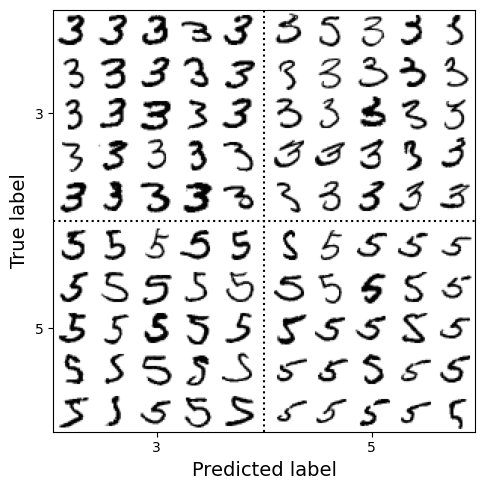

In [408]:
# extra code – this cell generates and saves Figure 3–11
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad) # %运算符取余数部分
        y = idx // size + label_row * (size + pad) # //运算符取整数部分
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)]) # 设置x坐标在指定位置的显示
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)]) # 设置y坐标在指定位置的显示
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:") # 画分割线
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad]) # 整个图像的x,y尺寸
plt.xlabel("Predicted label")
plt.ylabel("True label")
save_fig("error_analysis_digits_plot")
plt.show()

Note: there are several other ways you could code a plot like this one, but it's a bit hard to get the axis labels right:
* using [nested GridSpecs](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/gridspec_nested.html)
* merging all the digits in each block into a single image (then using 2×2 subplots). For example:
    ```python
    X_aa[:25].reshape(5, 5, 28, 28).transpose(0, 2, 1, 3).reshape(5 * 28, 5 * 28)
    ```
* using [subfigures](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subfigures.html) (since Matplotlib 3.4)

# Multilabel Classification

In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

In [ ]:
knn_clf.predict([some_digit])

**Warning**: the following cell may take a few minutes to run:

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

In [ ]:
# extra code – shows that we get a negligible performance improvement when we
#              set average="weighted" because the classes are already pretty
#              well balanced.
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

In [ ]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

In [ ]:
chain_clf.predict([some_digit])

# Multioutput Classification

In [ ]:
np.random.seed(42)  # to make this code example reproducible
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
# extra code – this cell generates and saves Figure 3–12
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
save_fig("noisy_digit_example_plot")
plt.show()

In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")  # extra code – saves Figure 3–13
plt.show()

# Exercise solutions

## 1. An MNIST Classifier With Over 97% Accuracy

Exercise: _Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the `KNeighborsClassifier` works quite well for this task; you just need to find good hyperparameter values (try a grid search on the `weights` and `n_neighbors` hyperparameters)._

Let's start with a simple K-Nearest Neighbors classifier and measure its performance on the test set. This will be our baseline:

In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
baseline_accuracy = knn_clf.score(X_test, y_test)
baseline_accuracy

Great! A regular KNN classifier with the default hyperparameters is already very close to our goal.

Let's see if tuning the hyperparameters can help. To speed up the search, let's train only on the first 10,000 images:

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5, 6]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5)
grid_search.fit(X_train[:10_000], y_train[:10_000])

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_

The score dropped, but that was expected since we only trained on 10,000 images. So let's take the best model and train it again on the full training set:

In [ ]:
grid_search.best_estimator_.fit(X_train, y_train)
tuned_accuracy = grid_search.score(X_test, y_test)
tuned_accuracy

We reached our goal of 97% accuracy! 🥳

## 2. Data Augmentation

Exercise: _Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. You can use the `shift()` function from the `scipy.ndimage` module. For example, `shift(image, [2, 1], cval=0)` shifts the image two pixels down and one pixel to the right. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called _data augmentation_ or _training set expansion_._

Let's try augmenting the MNIST dataset by adding slightly shifted versions of each image.

In [ ]:
from scipy.ndimage import shift

In [ ]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

Let's see if it works:

In [ ]:
image = X_train[1000]  # some random digit to demo
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("Original")
plt.imshow(image.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down")
plt.imshow(shifted_image_down.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left")
plt.imshow(shifted_image_left.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.show()

Looks good! Now let's create an augmented training set by shifting every image left, right, up and down by one pixel:

In [ ]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((-1, 0), (1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

Let's shuffle the augmented training set, or else all shifted images will be grouped together:

In [ ]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

Now let's train the model using the best hyperparameters we found in the previous exercise:

In [ ]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [ ]:
knn_clf.fit(X_train_augmented, y_train_augmented)

**Warning**: the following cell may take a few minutes to run:

In [ ]:
augmented_accuracy = knn_clf.score(X_test, y_test)
augmented_accuracy

By simply augmenting the data, we've got a 0.5% accuracy boost. Perhaps it does not sound so impressive, but it actually means that the error rate dropped significantly:

In [ ]:
error_rate_change = (1 - augmented_accuracy) / (1 - tuned_accuracy) - 1
print(f"error_rate_change = {error_rate_change:.0%}")

The error rate dropped quite a bit thanks to data augmentation.

## 3. Tackle the Titanic dataset

Exercise: _Tackle the Titanic dataset. A great place to start is on [Kaggle](https://www.kaggle.com/c/titanic). Alternatively, you can download the data from https://homl.info/titanic.tgz and unzip this tarball like you did for the housing data in Chapter 2. This will give you two CSV files: _train.csv_ and _test.csv_ which you can load using `pandas.read_csv()`. The goal is to train a classifier that can predict the `Survived` column based on the other columns._

Let's fetch the data and load it:

In [ ]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_titanic_data():
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="datasets")
    return [pd.read_csv(Path("datasets/titanic") / filename)
            for filename in ("train.csv", "test.csv")]

In [ ]:
train_data, test_data = load_titanic_data()

The data is already split into a training set and a test set. However, the test data does *not* contain the labels: your goal is to train the best model you can on the training data, then make your predictions on the test data and upload them to Kaggle to see your final score.

Let's take a peek at the top few rows of the training set:

In [ ]:
train_data.head()

The attributes have the following meaning:
* **PassengerId**: a unique identifier for each passenger
* **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* **Pclass**: passenger class.
* **Name**, **Sex**, **Age**: self-explanatory
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
* **Parch**: how many children & parents of the passenger aboard the Titanic.
* **Ticket**: ticket id
* **Fare**: price paid (in pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic

The goal is to predict whether or not a passenger survived based on attributes such as their age, sex, passenger class, where they embarked and so on.

Let's explicitly set the `PassengerId` column as the index column:

In [ ]:
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

Let's get more info to see how much data is missing:

In [ ]:
train_data.info()

In [ ]:
train_data[train_data["Sex"]=="female"]["Age"].median()

Okay, the **Age**, **Cabin** and **Embarked** attributes are sometimes null (less than 891 non-null), especially the **Cabin** (77% are null). We will ignore the **Cabin** for now and focus on the rest. The **Age** attribute has about 19% null values, so we will need to decide what to do with them. Replacing null values with the median age seems reasonable. We could be a bit smarter by predicting the age based on the other columns (for example, the median age is 37 in 1st class, 29 in 2nd class and 24 in 3rd class), but we'll keep things simple and just use the overall median age.

The **Name** and **Ticket** attributes may have some value, but they will be a bit tricky to convert into useful numbers that a model can consume. So for now, we will ignore them.

Let's take a look at the numerical attributes:

In [ ]:
train_data.describe()

* Yikes, only 38% **Survived**! 😭 That's close enough to 40%, so accuracy will be a reasonable metric to evaluate our model.
* The mean **Fare** was £32.20, which does not seem so expensive (but it was probably a lot of money back then).
* The mean **Age** was less than 30 years old.

Let's check that the target is indeed 0 or 1:

In [ ]:
train_data["Survived"].value_counts()

Now let's take a quick look at all the categorical attributes:

In [ ]:
train_data["Pclass"].value_counts()

In [ ]:
train_data["Sex"].value_counts()

In [ ]:
train_data["Embarked"].value_counts()

The Embarked attribute tells us where the passenger embarked: C=Cherbourg, Q=Queenstown, S=Southampton.

Now let's build our preprocessing pipelines, starting with the pipeline for numerical attributes:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

Now we can build the pipeline for the categorical attributes:

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

Note: the `sparse` hyperparameter below was renamed to `sparse_output`.

In [ ]:
cat_pipeline = Pipeline([
        ("ordinal_encoder", OrdinalEncoder()),    
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse_output=False)),
    ])

Finally, let's join the numerical and categorical pipelines:

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

Cool! Now we have a nice preprocessing pipeline that takes the raw data and outputs numerical input features that we can feed to any Machine Learning model we want.

In [ ]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

Let's not forget to get the labels:

In [ ]:
y_train = train_data["Survived"]

We are now ready to train a classifier. Let's start with a `RandomForestClassifier`:

In [ ]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

Great, our model is trained, let's use it to make predictions on the test set:

In [ ]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = forest_clf.predict(X_test)

And now we could just build a CSV file with these predictions (respecting the format expected by Kaggle), then upload it and hope for the best. But wait! We can do better than hope. Why don't we use cross-validation to have an idea of how good our model is?

In [ ]:
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

Okay, not too bad! Looking at the [leaderboard](https://www.kaggle.com/c/titanic/leaderboard) for the Titanic competition on Kaggle, you can see that our score is in the top 2%, woohoo! Some Kagglers reached 100% accuracy, but since you can easily find the [list of victims](https://www.encyclopedia-titanica.org/titanic-victims/) of the Titanic, it seems likely that there was little Machine Learning involved in their performance! 😆

Let's try an `SVC`:

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

Great! This model looks better.

But instead of just looking at the mean accuracy across the 10 cross-validation folds, let's plot all 10 scores for each model, along with a box plot highlighting the lower and upper quartiles, and "whiskers" showing the extent of the scores (thanks to Nevin Yilmaz for suggesting this visualization). Note that the `boxplot()` function detects outliers (called "fliers") and does not include them within the whiskers. Specifically, if the lower quartile is $Q_1$ and the upper quartile is $Q_3$, then the interquartile range $IQR = Q_3 - Q_1$ (this is the box's height), and any score lower than $Q_1 - 1.5 \times IQR$ is a flier, and so is any score greater than $Q3 + 1.5 \times IQR$.

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM", "Random Forest"))
plt.ylabel("Accuracy")
plt.show()

The random forest classifier got a very high score on one of the 10 folds, but overall it had a lower mean score, as well as a bigger spread, so it looks like the SVM classifier is more likely to generalize well.

To improve this result further, you could:
* Compare many more models and tune hyperparameters using cross validation and grid search,
* Do more feature engineering, for example:
  * Try to convert numerical attributes to categorical attributes: for example, different age groups had very different survival rates (see below), so it may help to create an age bucket category and use it instead of the age. Similarly, it may be useful to have a special category for people traveling alone since only 30% of them survived (see below).
  * Replace **SibSp** and **Parch** with their sum.
  * Try to identify parts of names that correlate well with the **Survived** attribute.
  * Use the **Cabin** column, for example take its first letter and treat it as a categorical attribute.

In [ ]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

In [ ]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(
    ['RelativesOnboard']).mean()

## 4. Spam classifier

Exercise: _Build a spam classifier (a more challenging exercise):_

* _Download examples of spam and ham from [Apache SpamAssassin's public datasets](https://homl.info/spamassassin)._
* _Unzip the datasets and familiarize yourself with the data format._
* _Split the datasets into a training set and a test set._
* _Write a data preparation pipeline to convert each email into a feature vector. Your preparation pipeline should transform an email into a (sparse) vector that indicates the presence or absence of each possible word. For example, if all emails only ever contain four words, "Hello," "how," "are," "you," then the email "Hello you Hello Hello you" would be converted into a vector [1, 0, 0, 1] (meaning [“Hello" is present, "how" is absent, "are" is absent, "you" is present]), or [3, 0, 0, 2] if you prefer to count the number of occurrences of each word._

_You may want to add hyperparameters to your preparation pipeline to control whether or not to strip off email headers, convert each email to lowercase, remove punctuation, replace all URLs with "URL," replace all numbers with "NUMBER," or even perform _stemming_ (i.e., trim off word endings; there are Python libraries available to do this)._

_Finally, try out several classifiers and see if you can build a great spam classifier, with both high recall and high precision._

In [ ]:
import tarfile

def fetch_spam_data():
    spam_root = "http://spamassassin.apache.org/old/publiccorpus/"
    ham_url = spam_root + "20030228_easy_ham.tar.bz2"
    spam_url = spam_root + "20030228_spam.tar.bz2"

    spam_path = Path() / "datasets" / "spam"
    spam_path.mkdir(parents=True, exist_ok=True)
    for dir_name, tar_name, url in (("easy_ham", "ham", ham_url),
                                    ("spam", "spam", spam_url)):
        if not (spam_path / dir_name).is_dir():
            path = (spam_path / tar_name).with_suffix(".tar.bz2")
            print("Downloading", path)
            urllib.request.urlretrieve(url, path)
            tar_bz2_file = tarfile.open(path)
            tar_bz2_file.extractall(path=spam_path)
            tar_bz2_file.close()
    return [spam_path / dir_name for dir_name in ("easy_ham", "spam")]

In [ ]:
ham_dir, spam_dir = fetch_spam_data()

Next, let's load all the emails:

In [ ]:
ham_filenames = [f for f in sorted(ham_dir.iterdir()) if len(f.name) > 20]
spam_filenames = [f for f in sorted(spam_dir.iterdir()) if len(f.name) > 20]

In [ ]:
len(ham_filenames)

In [ ]:
len(spam_filenames)

We can use Python's `email` module to parse these emails (this handles headers, encoding, and so on):

In [ ]:
import email
import email.policy

def load_email(filepath):
    with open(filepath, "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [ ]:
ham_emails = [load_email(filepath) for filepath in ham_filenames]
spam_emails = [load_email(filepath) for filepath in spam_filenames]

Let's look at one example of ham and one example of spam, to get a feel of what the data looks like:

In [ ]:
print(ham_emails[1].get_content().strip())

In [ ]:
print(spam_emails[6].get_content().strip())

Some emails are actually multipart, with images and attachments (which can have their own attachments). Let's look at the various types of structures we have:

In [ ]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        multipart = ", ".join([get_email_structure(sub_email)
                               for sub_email in payload])
        return f"multipart({multipart})"
    else:
        return email.get_content_type()

In [ ]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [ ]:
structures_counter(ham_emails).most_common()

In [ ]:
structures_counter(spam_emails).most_common()

It seems that the ham emails are more often plain text, while spam has quite a lot of HTML. Moreover, quite a few ham emails are signed using PGP, while no spam is. In short, it seems that the email structure is useful information to have.

Now let's take a look at the email headers:

In [ ]:
for header, value in spam_emails[0].items():
    print(header, ":", value)

There's probably a lot of useful information in there, such as the sender's email address (12a1mailbot1@web.de looks fishy), but we will just focus on the `Subject` header:

In [ ]:
spam_emails[0]["Subject"]

Okay, before we learn too much about the data, let's not forget to split it into a training set and a test set:

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

Okay, let's start writing the preprocessing functions. First, we will need a function to convert HTML to plain text. Arguably the best way to do this would be to use the great [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) library, but I would like to avoid adding another dependency to this project, so let's hack a quick & dirty solution using regular expressions (at the risk of [un̨ho͞ly radiańcé destro҉ying all enli̍̈́̂̈́ghtenment](https://stackoverflow.com/a/1732454/38626)). The following function first drops the `<head>` section, then converts all `<a>` tags to the word HYPERLINK, then it gets rid of all HTML tags, leaving only the plain text. For readability, it also replaces multiple newlines with single newlines, and finally it unescapes html entities (such as `&gt;` or `&nbsp;`):

In [ ]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

Let's see if it works. This is HTML spam:

In [ ]:
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

And this is the resulting plain text:

In [ ]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")

Great! Now let's write a function that takes an email as input and returns its content as plain text, whatever its format is:

In [ ]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [ ]:
print(email_to_text(sample_html_spam)[:100], "...")

Let's throw in some stemming! We will use the Natural Language Toolkit ([NLTK](http://www.nltk.org/)):

In [ ]:
import nltk

stemmer = nltk.PorterStemmer()
for word in ("Computations", "Computation", "Computing", "Computed", "Compute",
             "Compulsive"):
    print(word, "=>", stemmer.stem(word))

We will also need a way to replace URLs with the word "URL". For this, we could use hard core [regular expressions](https://mathiasbynens.be/demo/url-regex) but we will just use the [urlextract](https://github.com/lipoja/URLExtract) library:

In [ ]:
# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# if running this notebook on Colab or Kaggle, we just pip install urlextract
if IS_COLAB or IS_KAGGLE:
    %pip install -q -U urlextract

**Note:** inside a Jupyter notebook, always use `%pip` instead of `!pip`, as `!pip` may install the library inside the wrong environment, while `%pip` makes sure it's installed inside the currently running environment.

In [ ]:
import urlextract # may require an Internet connection to download root domain
                  # names

url_extractor = urlextract.URLExtract()
some_text = "Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"
print(url_extractor.find_urls(some_text))

We are ready to put all this together into a transformer that we will use to convert emails to word counters. Note that we split sentences into words using Python's `split()` method, which uses whitespaces for word boundaries. This works for many written languages, but not all. For example, Chinese and Japanese scripts generally don't use spaces between words, and Vietnamese often uses spaces even between syllables. It's okay in this exercise, because the dataset is (mostly) in English.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True,
                 remove_punctuation=True, replace_urls=True,
                 replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

Let's try this transformer on a few emails:

In [ ]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

This looks about right!

Now we have the word counts, and we need to convert them to vectors. For this, we will build another transformer whose `fit()` method will build the vocabulary (an ordered list of the most common words) and whose `transform()` method will use the vocabulary to convert word counts to vectors. The output is a sparse matrix.

In [ ]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: index + 1
                            for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)),
                          shape=(len(X), self.vocabulary_size + 1))

In [ ]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

In [ ]:
X_few_vectors.toarray()

What does this matrix mean? Well, the 99 in the second row, first column, means that the second email contains 99 words that are not part of the vocabulary. The 11 next to it means that the first word in the vocabulary is present 11 times in this email. The 9 next to it means that the second word is present 9 times, and so on. You can look at the vocabulary to know which words we are talking about. The first word is "the", the second word is "of", etc.

In [ ]:
vocab_transformer.vocabulary_

We are now ready to train our first spam classifier! Let's transform the whole dataset:

In [ ]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(max_iter=1000, random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3)
score.mean()

Over 98.5%, not bad for a first try! :) However, remember that we are using the "easy" dataset. You can try with the harder datasets, the results won't be so amazing. You would have to try multiple models, select the best ones and fine-tune them using cross-validation, and so on.

But you get the picture, so let's stop now, and just print out the precision/recall we get on the test set:

In [ ]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(max_iter=1000, random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print(f"Precision: {precision_score(y_test, y_pred):.2%}")
print(f"Recall: {recall_score(y_test, y_pred):.2%}")

In [ ]:
time.time() - start